In [253]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.python.ops import math_ops as tfmath_ops
# from utils import Make_Video_batch, make_checkpoint_folder
# from utils import build_video_batch_graph, plot_latents, MSE_rotation
# from utils import pandas_res_saver
import sys
import time
import pickle
import os
# from utils_circles_grid import Make_circles, Make_squares, plot_circle
# from utils_circles_grid import plot_heatmap, plot_square
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [230]:
def Make_path_batch(
    batch=40,
    tmax=30,
    lt=5,
    seed=None
    ):
    """
    Samples x(t), y(t) from a GP
    args:
        batch: number of samples
        tmax: length of samples
        lt: GP length scale
    returns:
        traj: nparray (batch, tmax, 2)
    """

    ilt = -0.5/(lt*lt)
    T = np.arange(tmax)

    Sigma = np.exp( ilt * (T.reshape(-1,1) - T.reshape(1,-1))**2)
#     print(Sigma.shape)
    Mu = np.zeros(tmax)
#     print(Mu.shape)

    np.random.seed(seed)

    traj = np.random.multivariate_normal(Mu, Sigma, (batch, 3))
    traj = np.transpose(traj, (0,2,1))

    return traj

def Make_Video_batch(tmax=50,
    px=10,
    py=10,
    pz=10,
    lt=5,
    batch=40,
    seed=1,
    r=2
    ):
    """
    params:
        tmax: number of frames to generate
        px: horizontal resolution
        py: vertical resolution
        lt: length scale
        batch: number of videos
        seed: rng seed
        r: radius of ball in pixels
    
    returns:
        traj0: (batch, tmax, 2) numpy array
        vid_batch: (batch, tmax, px, py) numpy array
    """


    traj0 = Make_path_batch(batch=batch, tmax=tmax, lt=lt)

    traj = traj0.copy()

    # convert trajectories to pixel dims
    traj[:,:,0] = traj[:,:,0] * (px/5) + (0.5*px)
    traj[:,:,1] = traj[:,:,1] * (py/5) + (0.5*py)
    traj[:,:,2] = traj[:,:,2] * (pz/5) + (0.5*pz)

    rr = r*r*r

    def pixelate_frame(xy):
        """
        takes a single x,y pixel point and converts to binary image
        with ball centered at x,y.
        """
        x = xy[0]
        y = xy[1]

        sq_x = (np.arange(px) - x)**2
        sq_y = (np.arange(py) - y)**2

        sq = sq_x.reshape(1,-1) + sq_y.reshape(-1,1)

        image = 1*(sq < rr)

        return image

    
    def pixelate_series(XY):
        vid = map(pixelate_frame, XY)
        vid = [v for v in vid]
        return np.asarray(vid)


    vid_batch = [pixelate_series(traj_i) for traj_i in traj]

    vid_batch = np.asarray(vid_batch)

    return traj0#, vid_batch

In [3]:
def gauss_cross_entropy(mu1, var1, mu2, var2):
    """
    Computes the element-wise cross entropy
    Given q(z) ~ N(z| mu1, var1)
    returns E_q[ log N(z| mu2, var2) ]
    args:
        mu1:  mean of expectation (batch, tmax, 2) tf variable
        var1: var  of expectation (batch, tmax, 2) tf variable
        mu2:  mean of integrand (batch, tmax, 2) tf variable
        var2: var of integrand (batch, tmax, 2) tf variable

    returns:
        cross_entropy: (batch, tmax, 2) tf variable
    """
    term0 = 1.8378770664093453 # log(2*pi)
    term1 = tf.log(var2)
    term2 = (var1 + mu1**2 - 2*mu1*mu2 + mu2**2) / var2
    cross_entropy = -0.5*( term0 + term1 + term2 )
    return cross_entropy


def gauss_entropy(var1):
    """
    Computes the element-wise entropy
    Given q(z) ~ N(z| mu1, var1)
    returns E_q[ log N(z| mu1, var1) ] = -0.5 ( log(var1) + 1 + log(2*pi) )
    args:
        var1: var  of expectation (batch, tmax, 2) tf variable

    returns:
        cross_entropy: (batch, tmax, 2) tf variable
    """
    term0 = tf.log(var1) + 2.8378770664093453 # 1 + log(2*pi)
    cross_entropy = -0.5*( term0 )
    return cross_entropy


def build_MLP_inference_graph(vid_batch, layers=[500], tftype=tf.float32):
    """
    Takes a placeholder for batches of videos to be fed in, returns 
    a mean and var of 2d latent space that are tf variables.

    args:
        vid_batch: tf placeholder (batch, tmax, width, height)
        layers: list of widths of fully connected layers
        tftype: data type to use in graph

    returns:
        means:  tf variable, (batch, tmax, 2) x,y points
        vars:  tf variable, (batch, tmax, 2) x,y uncertainties
    """

    batch, tmax, px, py = vid_batch.get_shape()

    # first layer, flatten images to vectors
    h0 = tf.reshape(vid_batch, (batch*tmax, px*py))

    # loop over layers in given list
    for l in layers:
        i_dims = int(h0.get_shape()[-1])
        W = tf.Variable(tf.truncated_normal([i_dims, l],
                stddev=1.0 / np.sqrt(float(i_dims))), name="encW")
        B = tf.Variable(tf.zeros([1, l]), name="encB")
        h0 = tf.matmul(h0, W) + B
        h0 = tf.nn.tanh(h0)

    # final layer just outputs x,y mean and log(var) of q network
    i_dims = int(h0.get_shape()[-1])
    W = tf.Variable(tf.truncated_normal([i_dims, 6],
            stddev=1.0 / np.sqrt(float(i_dims))), name="encW")
    B = tf.Variable(tf.zeros([1, 6]), name="encB")
    h0 = tf.matmul(h0, W) + B

    h0 = tf.reshape(h0, (batch, tmax, 6))

    #First 2 mean Next 2 variance
    q_means = h0[:, :, :3]
    q_vars  = tf.exp(h0[:, :, 3:])

    return q_means, q_vars

def build_MLP_decoder_graph(latent_samples, px, py, layers=[500]):
    """
    Constructs a TF graph that goes from latent points in 2D time series
    to a bernoulli probabilty for each pixel in output video time series.
    Args:
        latent_samples: (batch, tmax, 2), tf variable
        px: image width (int)
        py: image height (int)
        layers: list of num. of nodes (list of ints)

    Returns:
        pred_batch_vid_logits: (batch, tmax, px, py) tf variable
    """
    batch, tmax, _ = latent_samples.get_shape()
    # flatten all latents into one matrix (decoded in i.i.d fashion)
    h0 = tf.reshape(latent_samples, (batch*tmax, 3))

    # loop over layers in given list
    for l in layers:
        i_dims = int(h0.get_shape()[-1])
        W = tf.Variable(tf.truncated_normal([i_dims, l],
                stddev=1.0 / np.sqrt(float(i_dims))), name="decW")
        B = tf.Variable(tf.zeros([1, l]), name="decB")
        h0 = tf.matmul(h0, W) + B
        h0 = tf.nn.tanh(h0)

    # final layer just outputs full video batch
    l = px*py
    i_dims = int(h0.get_shape()[-1])
    W = tf.Variable(tf.truncated_normal([i_dims, l],
            stddev=1.0 / np.sqrt(float(i_dims))), name="decW")
    B = tf.Variable(tf.zeros([1, l]), name="decB")
    h0 = tf.matmul(h0, W) + B
    pred_vid_batch_logits = tf.reshape(h0, (batch, tmax, px, py))
    return pred_vid_batch_logits

def build_1d_gp(X, Y, varY, X_test, lt=5):
    """
    Takes input-output dataset and returns post mean, var, marginal lhood.
    This is standard GP regression (in this application X is time, Y is 
    recognition network means with noise as recognition netowrk variance).

    Args:
        X: inputs tensor (batch, npoints)
        Y: outputs tensor (batch, npoints)
        varY: noise of outputs tensor (batch, npoints)
        X_test: (batch, ns) input points to compute post mean + var

    Returns:
        p_m: (batch, ns) post mean at X_test
        p_v: (batch, ns) post var at X_test
        logZ: (batch) marginal lhood of each dataset in batch
    """

    # Prepare all constants
    batch, _ = X.get_shape()
    n = tf.shape(X)[1]
    _, ns = X_test.get_shape()

    # inverse square length scale
    ilt = tf.constant( -0.5*(1/(lt*lt)) )
    
    # lhood term 1/3
    lhood_pi_term = tf.cast(n, dtype=tf.float32) * np.log(2*np.pi)
    
    # data cov matrix K = exp( -1/2 * (X-X)**2/l**2) + noise
    K = tf.reshape(X, (batch, n, 1)) - tf.reshape(X, (batch, 1, n)) # (batch, n n)
    K = tf.exp( (K**2) * ilt)  + tf.matrix_diag(varY) 
    chol_K = tf.linalg.cholesky(K) # (batch, n, n)

    # lhood term 2/3
    lhood_logdet_term = 2*tf.reduce_sum(tf.log(tf.matrix_diag_part(chol_K)), 1) # (batch)

    # lhood term 3/3
    Y = tf.reshape(Y, (batch, n, 1))
    iKY = tf.cholesky_solve( chol_K, Y) # (batch, n, 1)
    lh_quad_term = tf.matmul(tf.reshape(Y, (batch, 1, n)), iKY) # (batch, 1, 1)
    lh_quad_term = tf.reshape(lh_quad_term, [batch])

    # log P(Y|X) = -1/2 * ( n log(2 pi) + Y inv(K+noise) Y + log det(K+noise))
    gp_lhood = -0.5*( lhood_pi_term + lh_quad_term + lhood_logdet_term )

    # Compute posterior mean and variances
    Ks = tf.reshape(X, (batch, n, 1)) - tf.reshape(X_test, (batch, 1, ns)) #broadcasts to (batch, n, ns)
    Ks = tf.exp( (Ks**2) * ilt) # (batch, n, ns)
    Ks_t = tf.transpose(Ks, (0, 2, 1)) # (batch, ns, n)

    # posterior mean
    p_m = tf.matmul(Ks_t, iKY)
    p_m = tf.reshape(p_m, (batch, ns))

    # posterior variance
    iK_Ks = tf.cholesky_solve(chol_K, Ks) # (batch, n, ns)
    Ks_iK_Ks = tf.reduce_sum(Ks * iK_Ks, axis=1) # (batch, ns)
    p_v = 1 - Ks_iK_Ks # (batch, ns)
    p_v = tf.reshape(p_v, (batch, ns))

    return p_m, p_v, gp_lhood

def build_sin_and_np_elbo_graphs(vid_batch, beta, lt=5, context_ratio=0.5):
    """
    Builds both standard (sin) eblo and neural process (np) elbo. 
    Returns pretty much everything!
    Args:
        vid_batch: tf variable (batch, tmax, px, py) binay arrays or images
        beta: scalar, tf variable, annealing term for prior KL
        lt: length scale of GP
        context_ratio: float in [0,1], for np elbo, random target-context split ratio

    Returns:
        sin_elbo: "standard" elbo
        sin_elbo_recon: recon struction term
        sin_elbo_prior_kl: prior KL term
        np_elbo: neural process elbo
        np_elbo_recon: ...
        np_prior_kl: ...
        full_p_mu: approx posterior mean
        full_p_var: approx post var
        qnet_mu: recognition network mean
        qnet_var: recog. net var
        pred_vid: reconstructed video
        globals(): aaaalll variables in local scope
    """

    batch, tmax, px, py = [int(s) for s in vid_batch.get_shape()]

    # Choose a random split of target-context for each batch
    con_tf = tf.random.normal(shape=(),
                              mean=context_ratio*float(tmax),
                              stddev=np.sqrt(context_ratio*(1-context_ratio)*float(tmax)))
    con_tf = tf.math.maximum(con_tf, 2)
    con_tf = tf.math.minimum(con_tf, int(tmax)-2)
    con_tf = tf.cast(tf.round(con_tf), tf.int32)

    dt = vid_batch.dtype
    
    # recognition network terms
    qnet_mu, qnet_var = build_MLP_inference_graph(vid_batch)

    ##################################################################
    ####################### CONTEXT LIKELIHOOD #######################
    # make random indices
    ran_ind = tf.range(tmax, dtype=tf.int32)
    ran_ind = [tf.random.shuffle(ran_ind) for i in range(batch)] # (batch, tmax)
    ran_ind = [tf.reshape(r_i, (1,tmax)) for r_i in ran_ind] # len batch list( (tmax), ..., (tmax) )
    ran_ind = tf.concat(ran_ind, 0) # ()

    con_ind = ran_ind[:, :con_tf]
    tar_ind = ran_ind[:, con_tf:]

    T = tf.range(tmax, dtype=dt)
    batch_T = tf.concat([tf.reshape(T, (1,tmax)) for i in range(batch)], 0) # (batch, tmax)

    # time stamps of context points
    con_T = [tf.gather(T, con_ind[i,:]) for i in range(batch)]
    con_T = [tf.reshape(ct, (1,con_tf)) for ct in con_T]
    con_T = tf.concat(con_T, 0)

    # encoded means of contet points
    con_lm = [tf.gather(qnet_mu[i,:,:], con_ind[i,:], axis=0) for i in range(batch)]
    con_lm = [tf.reshape(cm, (1,con_tf,2)) for cm in con_lm]
    con_lm = tf.concat(con_lm, 0)

    # encoded variances of context points
    con_lv = [tf.gather(qnet_var[i,:,:], con_ind[i,:], axis=0) for i in range(batch)]
    con_lv = [tf.reshape(cv, (1,con_tf,2)) for cv in con_lv]
    con_lv = tf.concat(con_lv, 0)

    # conext Lhoods
    _,_, con_lhoodx = build_1d_gp(con_T, con_lm[:,:,0], con_lv[:,:,0], batch_T)
    _,_, con_lhoody = build_1d_gp(con_T, con_lm[:,:,1], con_lv[:,:,1], batch_T)
    con_lhood = con_lhoodx + con_lhoody


    ####################################################################################
    #################### PriorKL 1/3: FULL APPROX POST AND LIKELIHOOD ##################

    # posterior and lhood for full dataset
    p_mx, p_vx, full_lhoodx = build_1d_gp(batch_T, qnet_mu[:,:,0], qnet_var[:,:,0], batch_T)
    p_my, p_vy, full_lhoody = build_1d_gp(batch_T, qnet_mu[:,:,1], qnet_var[:,:,1], batch_T)

    full_p_mu = tf.stack([p_mx, p_my], axis=2)
    full_p_var = tf.stack([p_vx, p_vy], axis=2)

    full_lhood = full_lhoodx + full_lhoody

    ####################################################################################
    ########################### PriorKL 2/3: CROSS ENTROPY TERMS #######################

    # cross entropy term
    sin_elbo_ce = gauss_cross_entropy(full_p_mu, full_p_var, qnet_mu, qnet_var) #(batch, tmax, 2)
    sin_elbo_ce = tf.reduce_sum(sin_elbo_ce, 2) # (batch, tmax)


    np_elbo_ce = [tf.gather(sin_elbo_ce[i,:], tar_ind[i,:]) for i in range(batch)] # (batch, con_tf)
    np_elbo_ce = [tf.reduce_sum(np_i) for np_i in np_elbo_ce] # list of scalars, len=batch

    np_elbo_ce = tf.stack(np_elbo_ce) # (batch)
    sin_elbo_ce = tf.reduce_sum(sin_elbo_ce, 1) # (batch)


    ####################################################################################
    ################################ Prior KL 3/3 ######################################

    sin_elbo_prior_kl = full_lhood - sin_elbo_ce
    np_prior_kl       = full_lhood - np_elbo_ce - con_lhood


    ####################################################################################
    ########################### RECONSTRUCTION TERMS ###################################

    epsilon = tf.random.normal(shape=(batch, tmax, 2))
    latent_samples = full_p_mu + epsilon * tf.sqrt(full_p_var)
    pred_vid_batch_logits = build_MLP_decoder_graph(latent_samples, px, py)
    pred_vid = tf.nn.sigmoid(pred_vid_batch_logits)
    recon_err = tf.nn.sigmoid_cross_entropy_with_logits(labels=vid_batch, 
                                                        logits=pred_vid_batch_logits)
    sin_elbo_recon = tf.reduce_sum(-recon_err, (2,3)) # (batch, tmax)

    np_elbo_recon = [tf.gather(sin_elbo_recon[i,:], tar_ind[i,:]) for i in range(batch)] # (batch, con_tf)
    np_elbo_recon = [tf.reduce_sum(np_i) for np_i in np_elbo_recon]

    # finally the reconstruction error for each objective!
    np_elbo_recon = tf.stack(np_elbo_recon)  # (batch)
    sin_elbo_recon = tf.reduce_sum(sin_elbo_recon, 1) # (batch)



    #####################################################################################
    ####################### PUT IT ALL TOGETHER  ########################################

    sin_elbo = sin_elbo_recon + beta * sin_elbo_prior_kl
    
    np_elbo  = np_elbo_recon + beta * np_prior_kl

    return sin_elbo, sin_elbo_recon, sin_elbo_prior_kl, \
           np_elbo,   np_elbo_recon,       np_prior_kl, \
           full_p_mu, full_p_var, \
           qnet_mu, qnet_var, pred_vid, globals()

In [231]:
def build_video_batch_graph(tmax=50,
    px=10,
    py=10,
    pz=10,
    lt=5,
    batch=1,
    seed=1,
    r=2,
    dtype=tf.float32):

#     assert px==py, "video batch graph assumes square frames"

    rr = r*r*r

    ilt = tf.constant(-0.5/(lt**2), dtype=dtype)

    K = tf.range(tmax, dtype=dtype)
    K = (tf.reshape(K, (tmax, 1)) - tf.reshape(K, (1, tmax)))**2
#     print(K.shape)

    # print((K*ilt).get_shape())
    # sys.exit()


    K = tf.exp(K*ilt) + 0.00001*tf.eye(tmax, dtype=dtype)
    chol_K = tf.Variable(tf.linalg.cholesky(K), trainable=False)

#     ran_Z = tf.random.normal((tmax, 2*batch))
    ran_Z = tf.random.normal((tmax, 3*batch))

    paths = tf.matmul(chol_K, ran_Z)
#     paths = tf.reshape(paths, (tmax, batch, 2))
    paths = tf.reshape(paths, (tmax, batch, 3))
    paths = tf.transpose(paths, (1,0,2))
#     print(paths.shape)

    # assumes px = py
    paths = paths*0.2*px + 0.5*px
    # paths[:,:,0] = paths[:,:,0]*0.2*px + 0.5*px
    # paths[:,:,1] = paths[:,:,1]*0.2*py + 0.5*py

    vid_batch = []

    tf_px = tf.range(px, dtype=dtype)
    tf_py = tf.range(py, dtype=dtype)
    tf_pz = tf.range(pz, dtype=dtype)
    for b in range(batch):
        frames_tmax = []
        for t in range(tmax):
            lx = tf.reshape((tf_px - paths[b,t,0])**2, (px, 1, 1))
            ly = tf.reshape((tf_py - paths[b,t,1])**2, (1, py, 1))
            lz = tf.reshape((tf_py - paths[b,t,2])**2, (1,1, pz))
#             print(lx.shape, ly.shape)
            frame = lx + ly +lz< rr
#             print(frame.shape)
            frames_tmax.append(tf.reshape(frame, (1,1,px,py, pz)))
        vid_batch.append(tf.concat(frames_tmax, 1))
        

    vid_batch = [tfmath_ops.cast(vid, dtype=dtype) for vid in vid_batch]
    vid_batch = tf.concat(vid_batch, 0)

    return vid_batch

x = build_video_batch_graph()
print(x)
# tf.print(x[0][0], output_stream=sys.stdout)
# tensor = tf.range(10)
# tf.print(tensor, output_stream=sys.stdout)

tf.Tensor(
[[[[[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   ...

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 1. 1. 0.]
    [0. 0. 0. ... 1. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 1. 0. 0.]
    [0. 0. 0. ... 1. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...

In [232]:
def build_MLP_inference_graph(vid_batch, layers=[500], tftype=tf.float32):
    """
    Takes a placeholder for batches of videos to be fed in, returns 
    a mean and var of 2d latent space that are tf variables.

    args:
        vid_batch: tf placeholder (batch, tmax, width, height)
        layers: list of widths of fully connected layers
        tftype: data type to use in graph

    returns:
        means:  tf variable, (batch, tmax, 2) x,y points
        vars:  tf variable, (batch, tmax, 2) x,y uncertainties
    """

    batch, tmax, px, py ,pz = vid_batch.get_shape()

    # first layer, flatten images to vectors
    h0 = tf.reshape(vid_batch, (batch*tmax, px*py*pz))

    # loop over layers in given list
    for l in layers:
        i_dims = int(h0.get_shape()[-1])
        W = tf.Variable(tf.truncated_normal([i_dims, l],
                stddev=1.0 / np.sqrt(float(i_dims))), name="encW")
        B = tf.Variable(tf.zeros([1, l]), name="encB")
        h0 = tf.matmul(h0, W) + B
        h0 = tf.nn.tanh(h0)

    # final layer just outputs x,y mean and log(var) of q network
    i_dims = int(h0.get_shape()[-1])
    W = tf.Variable(tf.truncated_normal([i_dims, 6],
            stddev=1.0 / np.sqrt(float(i_dims))), name="encW")
    B = tf.Variable(tf.zeros([1, 6]), name="encB")
    h0 = tf.matmul(h0, W) + B

    h0 = tf.reshape(h0, (batch, tmax, 6))

    q_means = h0[:, :, :3]
    q_vars  = tf.exp(h0[:, :, 3:])

    return q_means, q_vars

In [233]:


def build_MLP_decoder_graph(latent_samples, px, py,pz, layers=[500]):
    """
    Constructs a TF graph that goes from latent points in 2D time series
    to a bernoulli probabilty for each pixel in output video time series.
    Args:
        latent_samples: (batch, tmax, 2), tf variable
        px: image width (int)
        py: image height (int)
        layers: list of num. of nodes (list of ints)

    Returns:
        pred_batch_vid_logits: (batch, tmax, px, py) tf variable
    """

    batch, tmax, _ = latent_samples.get_shape()

    # flatten all latents into one matrix (decoded in i.i.d fashion)
#     h0 = tf.reshape(latent_samples, (batch*tmax, 2))
    h0 = tf.reshape(latent_samples, (batch*tmax, 3))

    # loop over layers in given list
    for l in layers:
        i_dims = int(h0.get_shape()[-1])
        W = tf.Variable(tf.truncated_normal([i_dims, l],
                stddev=1.0 / np.sqrt(float(i_dims))), name="decW")
        B = tf.Variable(tf.zeros([1, l]), name="decB")
        h0 = tf.matmul(h0, W) + B
        h0 = tf.nn.tanh(h0)

    # final layer just outputs full video batch
    l = px*py*pz
    i_dims = int(h0.get_shape()[-1])
    W = tf.Variable(tf.truncated_normal([i_dims, l],
            stddev=1.0 / np.sqrt(float(i_dims))), name="decW")
    B = tf.Variable(tf.zeros([1, l]), name="decB")
    h0 = tf.matmul(h0, W) + B

    pred_vid_batch_logits = tf.reshape(h0, (batch, tmax, px, py, pz))

    return pred_vid_batch_logits


In [234]:
def build_sin_and_np_elbo_graphs(vid_batch, beta, lt=5, context_ratio=0.5):
    """
    Builds both standard (sin) eblo and neural process (np) elbo. 
    Returns pretty much everything!
    Args:
        vid_batch: tf variable (batch, tmax, px, py) binay arrays or images
        beta: scalar, tf variable, annealing term for prior KL
        lt: length scale of GP
        context_ratio: float in [0,1], for np elbo, random target-context split ratio

    Returns:
        sin_elbo: "standard" elbo
        sin_elbo_recon: recon struction term
        sin_elbo_prior_kl: prior KL term
        np_elbo: neural process elbo
        np_elbo_recon: ...
        np_prior_kl: ...
        full_p_mu: approx posterior mean
        full_p_var: approx post var
        qnet_mu: recognition network mean
        qnet_var: recog. net var
        pred_vid: reconstructed video
        globals(): aaaalll variables in local scope
    """
    print("BHU0", vid_batch.get_shape())
    batch, tmax, px, py, pz= [int(s) for s in vid_batch.get_shape()]

    # Choose a random split of target-context for each batch
    con_tf = tf.random.normal(shape=(),
                              mean=context_ratio*float(tmax),
                              stddev=np.sqrt(context_ratio*(1-context_ratio)*float(tmax)))
    con_tf = tf.math.maximum(con_tf, 2)
    con_tf = tf.math.minimum(con_tf, int(tmax)-2)
    con_tf = tf.cast(tf.round(con_tf), tf.int32)

    dt = vid_batch.dtype
    
    # recognition network terms
    qnet_mu, qnet_var = build_MLP_inference_graph(vid_batch)

    ##################################################################
    ####################### CONTEXT LIKELIHOOD #######################
    # make random indices
    ran_ind = tf.range(tmax, dtype=tf.int32)
    ran_ind = [tf.random.shuffle(ran_ind) for i in range(batch)] # (batch, tmax)
    ran_ind = [tf.reshape(r_i, (1,tmax)) for r_i in ran_ind] # len batch list( (tmax), ..., (tmax) )
    ran_ind = tf.concat(ran_ind, 0) # ()

    con_ind = ran_ind[:, :con_tf]
    tar_ind = ran_ind[:, con_tf:]

    T = tf.range(tmax, dtype=dt)
    batch_T = tf.concat([tf.reshape(T, (1,tmax)) for i in range(batch)], 0) # (batch, tmax)

    # time stamps of context points
    con_T = [tf.gather(T, con_ind[i,:]) for i in range(batch)]
    con_T = [tf.reshape(ct, (1,con_tf)) for ct in con_T]
    con_T = tf.concat(con_T, 0)

    # encoded means of contet points
    con_lm = [tf.gather(qnet_mu[i,:,:], con_ind[i,:], axis=0) for i in range(batch)]
    con_lm = [tf.reshape(cm, (1,con_tf,3)) for cm in con_lm]
    con_lm = tf.concat(con_lm, 0)

    # encoded variances of context points
    con_lv = [tf.gather(qnet_var[i,:,:], con_ind[i,:], axis=0) for i in range(batch)]
    con_lv = [tf.reshape(cv, (1,con_tf,3)) for cv in con_lv]
    con_lv = tf.concat(con_lv, 0)

    # conext Lhoods
    _,_, con_lhoodx = build_1d_gp(con_T, con_lm[:,:,0], con_lv[:,:,0], batch_T)
    _,_, con_lhoody = build_1d_gp(con_T, con_lm[:,:,1], con_lv[:,:,1], batch_T)
    _,_, con_lhoodz = build_1d_gp(con_T, con_lm[:,:,2], con_lv[:,:,2], batch_T)
    con_lhood = con_lhoodx + con_lhoody + con_lhoodz


    ####################################################################################
    #################### PriorKL 1/3: FULL APPROX POST AND LIKELIHOOD ##################

    # posterior and lhood for full dataset
    p_mx, p_vx, full_lhoodx = build_1d_gp(batch_T, qnet_mu[:,:,0], qnet_var[:,:,0], batch_T)
    p_my, p_vy, full_lhoody = build_1d_gp(batch_T, qnet_mu[:,:,1], qnet_var[:,:,1], batch_T)
    p_mz, p_vz, full_lhoodz = build_1d_gp(batch_T, qnet_mu[:,:,2], qnet_var[:,:,2], batch_T)

    full_p_mu = tf.stack([p_mx, p_my, p_mz], axis=2)
    full_p_var = tf.stack([p_vx, p_vy, p_vz], axis=2)

    full_lhood = full_lhoodx + full_lhoody + full_lhoodz

    ####################################################################################
    ########################### PriorKL 2/3: CROSS ENTROPY TERMS #######################

    # cross entropy term
#     print("BHU", full_p_var.shape, full_p_mu.shape)
    sin_elbo_ce = gauss_cross_entropy(full_p_mu, full_p_var, qnet_mu, qnet_var) #(batch, tmax, 2)
    sin_elbo_ce = tf.reduce_sum(sin_elbo_ce, 2) # (batch, tmax)


    np_elbo_ce = [tf.gather(sin_elbo_ce[i,:], tar_ind[i,:]) for i in range(batch)] # (batch, con_tf)
    np_elbo_ce = [tf.reduce_sum(np_i) for np_i in np_elbo_ce] # list of scalars, len=batch

    np_elbo_ce = tf.stack(np_elbo_ce) # (batch)
    sin_elbo_ce = tf.reduce_sum(sin_elbo_ce, 1) # (batch)


    ####################################################################################
    ################################ Prior KL 3/3 ######################################

    sin_elbo_prior_kl = full_lhood - sin_elbo_ce
    np_prior_kl       = full_lhood - np_elbo_ce - con_lhood


    ####################################################################################
    ########################### RECONSTRUCTION TERMS ###################################

#     epsilon = tf.random.normal(shape=(batch, tmax, 2))
    epsilon = tf.random.normal(shape=(batch, tmax, 3))
    latent_samples = full_p_mu + epsilon * tf.sqrt(full_p_var)
#     pred_vid_batch_logits = build_MLP_decoder_graph(latent_samples, px, py)
    pred_vid_batch_logits = build_MLP_decoder_graph(latent_samples, px, py, pz)
    pred_vid = tf.nn.sigmoid(pred_vid_batch_logits)
    recon_err = tf.nn.sigmoid_cross_entropy_with_logits(labels=vid_batch, 
                                                        logits=pred_vid_batch_logits)
    sin_elbo_recon = tf.reduce_sum(-recon_err, (2,3, 4)) # (batch, tmax)
    print('BHU2',sin_elbo_recon.shape, sin_elbo_prior_kl.shape , recon_err.shape, vid_batch.shape)
    np_elbo_recon = [tf.gather(sin_elbo_recon[i,:], tar_ind[i,:]) for i in range(batch)] # (batch, con_tf)
    np_elbo_recon = [tf.reduce_sum(np_i) for np_i in np_elbo_recon]

    # finally the reconstruction error for each objective!
    np_elbo_recon = tf.stack(np_elbo_recon)  # (batch)
    sin_elbo_recon = tf.reduce_sum(sin_elbo_recon, 1) # (batch)



    #####################################################################################
    ####################### PUT IT ALL TOGETHER  ########################################
    print('BHU2',sin_elbo_recon.shape, sin_elbo_prior_kl.shape )

    sin_elbo = sin_elbo_recon + beta * sin_elbo_prior_kl
    
    np_elbo  = np_elbo_recon + beta * np_prior_kl

    return sin_elbo, sin_elbo_recon, sin_elbo_prior_kl, \
           np_elbo,   np_elbo_recon,       np_prior_kl, \
           full_p_mu, full_p_var, \
           qnet_mu, qnet_var, pred_vid, globals()


In [10]:
# s_elbo, s_rec, s_pkl, np_elbo, np_rec, np_pkl, \
#     p_m,p_v,q_m,q_v,pred_vid, _ = build_sin_and_np_elbo_graphs(vid_batch, beta, lt=model_lt)

In [11]:
# px=py=pz=10
# dtype=tf.float32
# tf_px = tf.range(px, dtype=dtype)
# tf_py = tf.range(py, dtype=dtype)
# tf_pz = tf.range(pz, dtype=dtype)
# lx = tf.reshape((tf_px - paths[b,t,0])**2, (px, 1))
# ly = tf.reshape((tf_py - paths[b,t,1])**2, (1, py))

In [12]:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

EXPERIMENTS

In [13]:
default_base_dir = os.getcwd()

parser = argparse.ArgumentParser(description='Train GPP-VAE')
parser.add_argument('--steps', type=int, default=50000, help='Number of steps of Adam')
parser.add_argument('--beta0', type=float, default=1, help='initial beta annealing value')
parser.add_argument('--elbo', type=str, choices=['SIN', 'NP'], default='SIN',
                     help='Structured Inf Nets ELBO or Neural Processes ELBO')
parser.add_argument('--modellt', type=float, default=5, help='time scale of model to fit to data')
parser.add_argument('--base_dir', type=str, default=default_base_dir, help='folder within a new dir is made for each run')
parser.add_argument('--expid', type=str, default="debug", help='give this experiment a name')
parser.add_argument('--ram', type=float, default=0.5, help='fraction of GPU ram to use')
parser.add_argument('--seed', type=int, default=None, help='seed for rng')

args = parser.parse_args([])

In [14]:
default_base_dir = os.getcwd()

parser = argparse.ArgumentParser(description='Train GPP-VAE')
parser.add_argument('--steps', type=int, default=50, help='Number of steps of Adam')
parser.add_argument('--beta0', type=float, default=1, help='initial beta annealing value')
parser.add_argument('--elbo', type=str, choices=['SIN', 'NP'], default='SIN',
                     help='Structured Inf Nets ELBO or Neural Processes ELBO')
parser.add_argument('--modellt', type=float, default=5, help='time scale of model to fit to data')
parser.add_argument('--base_dir', type=str, default=default_base_dir, help='folder within a new dir is made for each run')
parser.add_argument('--expid', type=str, default="debug", help='give this experiment a name')
parser.add_argument('--ram', type=float, default=0.5, help='fraction of GPU ram to use')
parser.add_argument('--seed', type=int, default=None, help='seed for rng')

args = parser.parse_args([])

In [15]:
# batch = 35
# tmax = 30
# px = 32
# py = 32
# r = 3
# vid_lt = 5
# model_lt = args.modellt
batch = 35
tmax = 30
px = 12
py = 12
pz = 12
r = 2
vid_lt = 5
model_lt = args.modellt

In [16]:
# beta = tf.compat.v1.placeholder(dtype=tf.float32, shape=())
# vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py,pz=pz, r=r, lt=vid_lt)
# s_elbo, s_rec, s_pkl, np_elbo, np_rec, np_pkl, \
#     p_m,p_v,q_m,q_v,pred_vid, _ = build_sin_and_np_elbo_graphs(vid_batch, beta, lt=model_lt)

In [245]:
graph = tf.Graph()
with graph.as_default():
    # Make all the graphs
    beta = tf.compat.v1.placeholder(dtype=tf.float32, shape=())
    vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py,pz=pz, r=r, lt=vid_lt)
    s_elbo, s_rec, s_pkl, np_elbo, np_rec, np_pkl, \
        p_m,p_v,q_m,q_v,pred_vid, _ = build_sin_and_np_elbo_graphs(vid_batch, beta, lt=model_lt)

    # The actual loss functions
    if args.elbo=="SIN":
        loss  = -tf.reduce_mean(s_elbo)
        e_elb = tf.reduce_mean(s_elbo)
        e_pkl = tf.reduce_mean(s_pkl)
        e_rec = tf.reduce_mean(s_rec)
    elif args.elbo=="NP":
        loss  = -tf.reduce_mean(np_elbo)
        e_elb = tf.reduce_mean(np_elbo)
        e_pkl = tf.reduce_mean(np_pkl)
        e_rec = tf.reduce_mean(np_rec)

    av_s_elbo = tf.reduce_mean(s_elbo)
    av_s_rec  = tf.reduce_mean(s_rec)
    av_s_pkl  = tf.reduce_mean(s_pkl)


    # Add optimizer ops to graph (minimizing neg elbo!), print out trainable vars
    global_step = tf.Variable(0, name='global_step',trainable=False)
    optimizer  = tf.compat.v1.train.AdamOptimizer()
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    optim_step = optimizer.minimize(loss=loss, 
                                    var_list=train_vars,
                                    global_step=global_step)
    print("\n\nTrainable variables:")
    for v in train_vars:
        print(v)


    # Initializer ops for the graph and saver
    init_op = tf.global_variables_initializer()
    saver = tf.compat.v1.train.Saver()


    # Results to be tracked and Pandas saver
    res_vars = [global_step,
                loss,
                av_s_elbo,
                av_s_rec,
                av_s_pkl,
                e_elb,
                e_rec,
                e_pkl,
                tf.math.reduce_min(q_v),
                tf.math.reduce_max(q_v),
                tf.math.reduce_min(p_v),
                tf.math.reduce_max(p_v)]
    res_names= ["Step",
                "Loss",
                "Test ELBO",
                "Test Reconstruction",
                "Test Prior KL",
                "Train ELBO",
                "Train Reconstruction",
                "Train Prior KL",
                "min qs_var",
                "max qs_var",
                "min q_var",
                "max q_var",
                "MSE",
                "Beta",
                "Time"]
        # Now let's start doing some computation!
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=args.ram)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

        # Attempt to restore weights
        try:
            saver.restore(sess, tf.train.latest_checkpoint(chkpnt_dir))
            print("\n\nRestored Model Weights")
        except:
            sess.run(init_op)
            print("\n\nInitialised Model Weights")

        # Start training that elbo!
        for t in range(args.steps):

            # Annealing factor for prior KL
            beta_t = 1 + (args.beta0-1) * np.exp(t/2000)
            print("hello", t)

            # Train: do an optim step
            _, g_s = sess.run([optim_step, global_step], {beta:beta_t})

BHU0 (35, 30, 32, 32, 32)
BHU2 (35, 30) (35,) (35, 30, 32, 32, 32) (35, 30, 32, 32, 32)
BHU2 (35,) (35,)


Trainable variables:
<tf.Variable 'encW:0' shape=(32768, 500) dtype=float32_ref>
<tf.Variable 'encB:0' shape=(1, 500) dtype=float32_ref>
<tf.Variable 'encW_1:0' shape=(500, 6) dtype=float32_ref>
<tf.Variable 'encB_1:0' shape=(1, 6) dtype=float32_ref>
<tf.Variable 'decW:0' shape=(3, 500) dtype=float32_ref>
<tf.Variable 'decB:0' shape=(1, 500) dtype=float32_ref>
<tf.Variable 'decW_1:0' shape=(500, 32768) dtype=float32_ref>
<tf.Variable 'decB_1:0' shape=(1, 32768) dtype=float32_ref>


Initialised Model Weights
hello 0
hello 1
hello 2
hello 3
hello 4
hello 5
hello 6
hello 7
hello 8
hello 9
hello 10
hello 11
hello 12
hello 13
hello 14
hello 15
hello 16
hello 17
hello 18
hello 19
hello 20
hello 21
hello 22
hello 23
hello 24
hello 25
hello 26
hello 27
hello 28
hello 29
hello 30
hello 31
hello 32
hello 33
hello 34
hello 35
hello 36
hello 37
hello 38
hello 39
hello 40
hello 41
hello 42
hel

In [247]:
print("HE")

HE


In [84]:
vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py,pz=pz, r=5, lt=vid_lt)
vid_batch[0][0][1]
# vid_batch2 = np.asarray(vid_batch)
# vid_batch2

<tf.Tensor: id=1155529, shape=(12, 12), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [80]:
vid_batch[0][0]

<tf.Tensor: id=1120681, shape=(12, 12, 12), dtype=float32, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
     

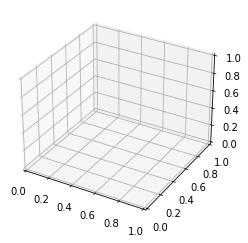

In [69]:
fig = plt.figure()
ax = plt.axes(projection='3d')

NameError: name 'yd' is not defined

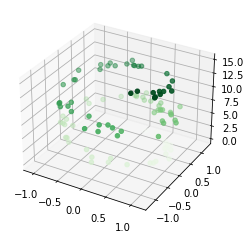

In [70]:
ax = plt.axes(projection='3d')

# # Data for a three-dimensional line
# zline = np.linspace(0, 15, 1000)
# xline = np.sin(zline)
# yline = np.cos(zline)
# ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

xd = vid_batch[0][0][0]
ax.scatter3D(xd,yd,zd, c=zdata, cmap='Greens');


In [82]:
 z,x,y = vid_batch[0][0].numpy().nonzero()
#     https://stackoverflow.com/questions/12414619/creating-a-3d-plot-from-a-3d-numpy-array

In [249]:
px=py=pz=32
r = 2
tmax=30
vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py,pz=pz, r=2, lt=vid_lt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


/Users/bhupendra/anaconda3/envs/gpvae1/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


23
24
25
26
27
28
29


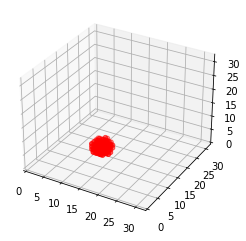

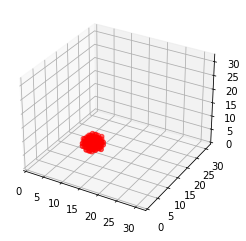

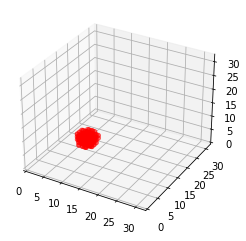

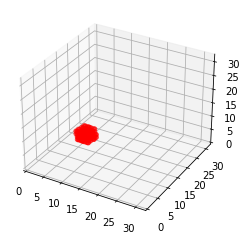

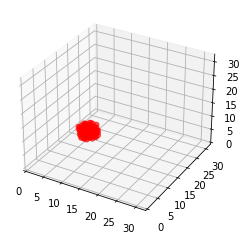

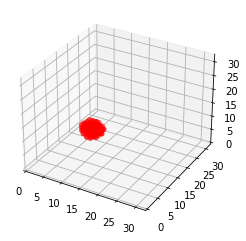

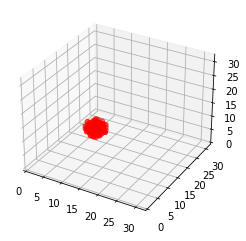

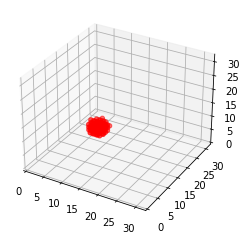

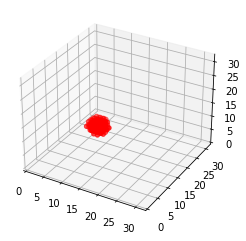

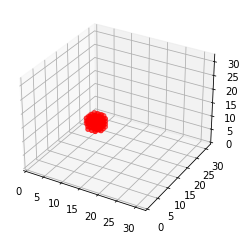

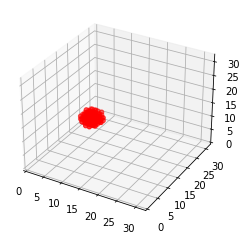

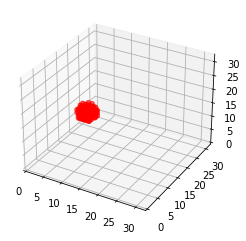

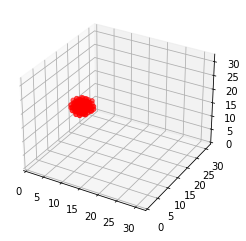

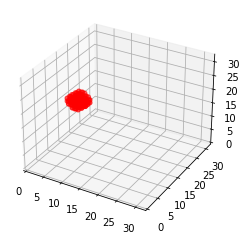

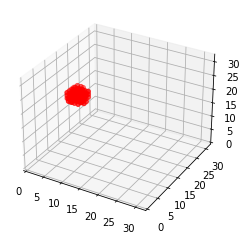

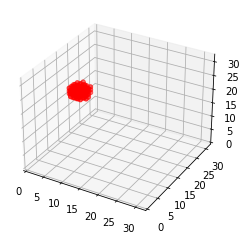

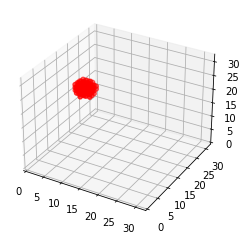

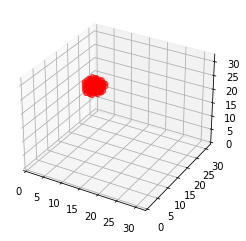

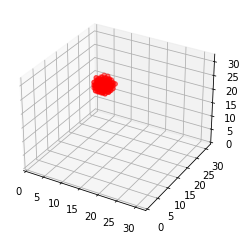

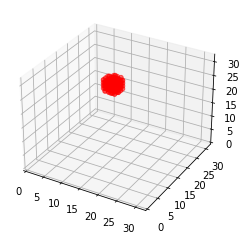

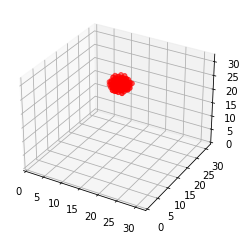

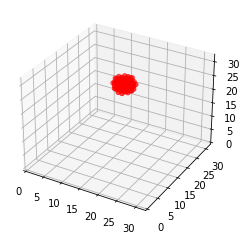

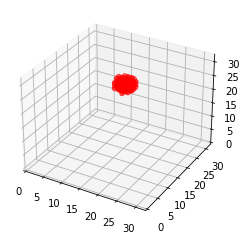

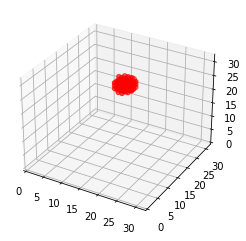

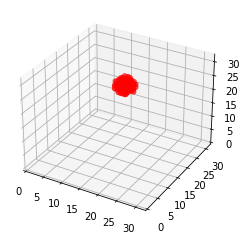

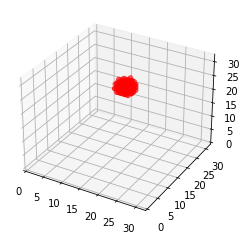

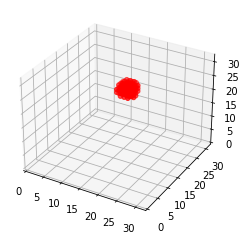

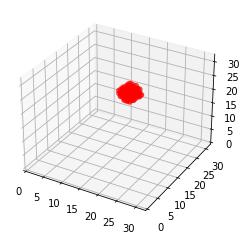

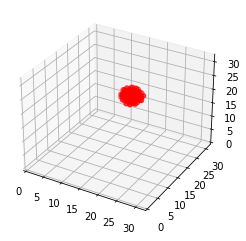

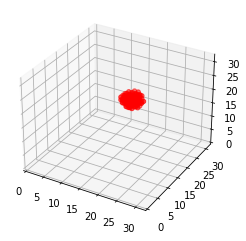

In [250]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for i in range(tmax):
    z,x,y = vid_batch[0][i].numpy().nonzero()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(0,px)
    ax.set_ylim(0,py)
    ax.set_zlim(0,pz)
    ax.scatter(x, y, z, zdir='z', c= 'red')
    plt.savefig("demo.png")

In [ ]:
px=py=pz=32
r = 2
tmax=40
vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py,pz=pz, r=2, lt=vid_lt)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0,px)
ax.set_ylim(0,py)
ax.set_zlim(0,pz)
for i in range(tmax):
    z,x,y = vid_batch[0][i].numpy().nonzero()
    ax.scatter(x, y, z, zdir='z', c= 'black', s=0.8)
    plt.savefig("demo.png")


In [258]:
# px=py=pz=32
# r = 2
# vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py,pz=pz, r=6, lt=vid_lt)
# for i in range(batch):
#     z,x,y = vid_batch[0][i].numpy().nonzero()
#     print(i)
#     print(x,y,z)

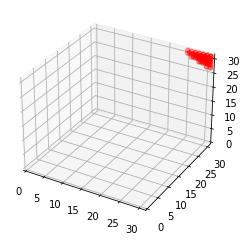

In [197]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z,x,y = vid_batch[0][9].numpy().nonzero()
ax.set_xlim(0,31)
ax.set_ylim(0,31)
ax.set_zlim(0,31)
ax.scatter(x, y, z, zdir='z', c= 'red')

In [248]:
vid_batch[0][9].numpy().nonzero()
# z

TypeError: provided list of inputs contains objects other than 'EagerTensor'. Item 0 is Tensor